In [6]:
import numpy as np
from datetime import datetime as dt,timedelta
import xarray as xr
import netCDF4 as nc
import os
import copy
import matplotlib.colors as mcolors
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cftime
# import xesmf as xe
import matplotlib.pyplot as plt
import sys
sys.path.append('../') # This allows import of lib that is one level up
from lib import driver
# from lib import plot 
from lib.tools import get_categorical_obs, get_categorical_fcst, get_heidke, get_rpss
# from lib import verif
from lib.tools import *
from lib import getCPCobs
from lib.getCPCobs import *
import xskillscore as xs
import warnings
warnings.filterwarnings("ignore")


In [4]:
def check_lat_order(dataset,verbose=False):
    """
    Check the order of latitude coordinates in the dataset.
    
    Parameters:
    - dataset: xarray.Dataset or xarray.DataArray
    
    Returns:
    - True if latitude is ordered from North to South (N to S).
    - False if latitude is ordered from South to North (S to N).
    - None if the order is ambiguous or the dataset is empty.
    """
    if 'latitude' in dataset.coords:
        dataset = dataset.rename_dims({'latitude': 'lat', 'longitude': 'lon'})

    lat_coords = dataset['lat']
    lat_diff = lat_coords.diff(dim='lat')
    if verbose:
        print(lat_diff)

    if (lat_diff < 0.).all():
        dataset= dataset.sel(lat=dataset.lat[::-1])
        print('change latitude from S to N')
        # print(dataset.lat)
    elif (lat_diff > 0.).all():
        dataset = dataset
        print('====latitude from S to N----')
        # print(dataset.lat)
    else:
        print('!!!!!! Latitude ambiguous or unordered !!!!!!')
    return(dataset)


In [6]:
varname = 'T2m'
# VERIFDIR = f'/Projects/jalbers_process/CPC_LIM/yuan_ming/CPC/Images_v2p0_reforecast/'
# VERIFDIR = f'/Projects/jalbers_process/CPC_LIM/yuan_ming/CPC/Images_v2p0_reproduce_2017/'
VERIFDIR = f'/Projects/jalbers_process/CPC_LIM/yuan_ming/CPC/Images_v2p0_zero_out_soil_moisture/'
anomvar = varname+'_anom'
spreadvar = varname+'_spread' 

start_date = "2017-01-01"
end_date   = "2017-01-31"
date_range = pd.date_range(start=start_date, end=end_date)
# files = [os.path.join(VERIFDIR,'T2m',f'{varname}.{date}.nc') for date in date_range.strftime('%Y%m%d')]
files = [os.path.join(VERIFDIR, date, varname,f'{varname}.{date}.nc') for date in date_range.strftime('%Y%m%d')]
ds = xr.open_mfdataset(files)
ds = check_lat_order(ds,verbose=False)

for label,lt in zip(['wk34'],[(21,28)]):
    # new dataset with current lead time. if more than one, concatenate lead times
    newds = xr.concat([ds.sel(lead_time=f'{i} days') for i in lt],dim='lead_time').mean('lead_time')
    anom   = newds[anomvar]
    spread = newds[spreadvar]

change latitude from S to N


In [7]:
ds_jra = xr.open_dataset('/Projects/jalbers_process/CPC_LIM/t2m_data_for_scoring/final_v2_11.27.2023/T2m.jra55.grid2.ForecastLead_34.2017to2017.nc')
ds_jra = check_lat_order(ds_jra,verbose=False)

obs_jra = ds_jra['cpc_anom_week34']
obs_jra = obs_jra.rename({'lons': 'lon'})
obs_jra = obs_jra.rename({'lats': 'lat'})
obs_jra = obs_jra.assign_coords(lon=ds_jra.lon.data)
obs_jra = obs_jra.assign_coords(lat=ds_jra.lat.data)


anom_J = ds_jra['lim_week34']
anom_J = anom_J.rename({'lons': 'lon'})
anom_J = anom_J.rename({'lats': 'lat'})
anom_J = anom_J.assign_coords(lon=ds_jra.lon.data)
anom_J = anom_J.assign_coords(lat=ds_jra.lat.data)
anom_J

====latitude from S to N----


<xarray.DataArray 'lim_week34' (time: 365, lat: 91, lon: 180)>
[5978700 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -90.0 -88.0 -86.0 -84.0 -82.0 ... 84.0 86.0 88.0 90.0
Dimensions without coordinates: time

In [8]:
skill_HSS = []
probability = []
observation = []

for i, date in enumerate(date_range):
# for i in np.array([0,1,2,3,4]):
    print(date)
    vCPC = obs_jra.isel(time=i)
    ANOM = anom_J.isel(time=i)# scoring John's data
    # ANOM = anom.isel(time=i)  # scoring my data
    SPREAD = spread.isel(time=i)
    mask   = xr.where(ANOM.isnull() | vCPC.isnull() | SPREAD.isnull() ,np.nan  ,1.)


    # Apply the mask to the datasets
    vCPC = vCPC.where(~mask.isnull(), drop=True)
    ANOM = ANOM.where(~mask.isnull(), drop=True)
    SPREAD = SPREAD.where(~mask.isnull(), drop=True)
   
    vCPC   = np.array(vCPC)[vCPC.notnull()]
    ANOM   = np.array(ANOM)[ANOM.notnull()]
    SPREAD = np.array(SPREAD)[SPREAD.notnull()]

    bounds = [-np.inf*np.ones(len(vCPC)),np.zeros(len(vCPC)),np.inf*np.ones(len(vCPC))]
    OBS = get_categorical_obs((vCPC,),bounds)[0]

    bounds = [-np.inf*np.ones(len(ANOM)),np.zeros(len(ANOM)),np.inf*np.ones(len(ANOM))]
    PROB = get_categorical_fcst((ANOM,),(SPREAD,),bounds)[0]

    HSS = get_heidke(PROB.T,OBS.T,categorical=True)

    skill_HSS.append(HSS)
    probability.append(PROB)
    observation.append(OBS)


2017-01-01 00:00:00
2017-01-02 00:00:00
2017-01-03 00:00:00
2017-01-04 00:00:00
2017-01-05 00:00:00
2017-01-06 00:00:00
2017-01-07 00:00:00
2017-01-08 00:00:00
2017-01-09 00:00:00
2017-01-10 00:00:00
2017-01-11 00:00:00
2017-01-12 00:00:00
2017-01-13 00:00:00
2017-01-14 00:00:00
2017-01-15 00:00:00
2017-01-16 00:00:00
2017-01-17 00:00:00
2017-01-18 00:00:00
2017-01-19 00:00:00
2017-01-20 00:00:00
2017-01-21 00:00:00
2017-01-22 00:00:00
2017-01-23 00:00:00
2017-01-24 00:00:00
2017-01-25 00:00:00
2017-01-26 00:00:00
2017-01-27 00:00:00
2017-01-28 00:00:00
2017-01-29 00:00:00
2017-01-30 00:00:00
2017-01-31 00:00:00


In [9]:
ds = xr.Dataset(
    {
        'observation':(['time','event','point'],np.array(observation)),
        'probability':(['time','event','point'],np.array(probability)),
        'HSS':(['time'],np.array(skill_HSS)),
    },
    coords={
        'time': date_range,
        'event': ('event',np.array([0,1]),{'long_name': 'cold and warm event probability'}),
        'point': np.arange(np.array(probability).shape[2]),
    }
)
ds

<xarray.Dataset>
Dimensions:      (time: 31, event: 2, point: 282)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-01-31
  * event        (event) int64 0 1
  * point        (point) int64 0 1 2 3 4 5 6 7 ... 275 276 277 278 279 280 281
Data variables:
    observation  (time, event, point) bool False False False ... False False
    probability  (time, event, point) float64 0.489 0.4424 ... 0.5819 0.5748
    HSS          (time) float64 -0.01418 -0.06383 -0.02837 ... 0.1348 0.2837

In [29]:
import scipy.io

# Load John's scoring .mat file
mat_data = scipy.io.loadmat('/Projects/jalbers_process/CPC_LIM/t2m_data_for_scoring/scoring_data/final_v2_11.27.2023/jra55/scoring_data_2017.mat')
start_date = "2017-01-01"
end_date   = "2017-07-31"
date_range = pd.date_range(start=start_date, end=end_date)
date_range.shape

year_all = date_range.year
year = year_all.unique()[0]

In [28]:
mat_data['HSS_LIM'][0][0:date_range.shape[0]].shape

(212,)

array([0, 1])

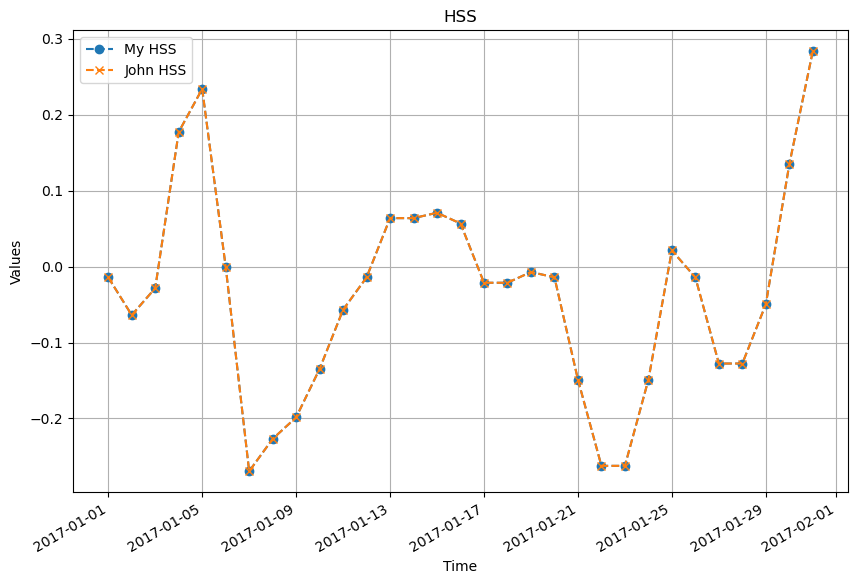

In [14]:
dsHSS= xr.Dataset({"HSS":(['time'],skill_HSS)}, coords={'time':date_range})
dsHSSJ = xr.Dataset({"HSS":(['time'],mat_data['HSS_LIM'][0][0:date_range.shape[0]-1])},coords={'time':date_range})

# Plotting
plt.figure(figsize=(10, 6))

# Plot HSS
# hss_data.plot(label='Reproduced HSS', marker='o', linestyle='-')

# Plot HSS_J
# hss_j_data.plot(label='John HSS', marker='x', linestyle='--')

dsHSS['HSS'].plot(label='My HSS', marker='o', linestyle='--')
dsHSSJ['HSS'].plot(label='John HSS', marker='x', linestyle='--')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('HSS')
plt.legend()
plt.grid(True)
plt.savefig('HSS.png')

In [12]:
print(ds['HSS'].mean())
print(dsHSSJ['HSS'].mean())

<xarray.DataArray 'HSS' ()>
array(-0.03568977)
<xarray.DataArray 'HSS' ()>
array(-0.03568977)


In [2]:
# year_all = date_range.year
# year = year_all.unique()[0]
# print(year)
# SCORDIR = f'{VERIFDIR}/verification'
# fout = f'{SCORDIR}/{year}.nc'
# os.system(f'mkdir -p {SCORDIR}')
# os.system(f'rm -f {fout}')
# ds.to_netcdf(fout)